In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from support.imu_calculations import *

In [2]:
_parent_folder = "omni_9dof_april_20_2023"
_folder_name = "sk32_00_random_slow_00"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.dirname(_base_pth)
_base_pth = os.path.join(_base_pth,"recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\Sujith\\Documents\\Projects\\armbo\\recording_programs\\test_data\\omni_9dof_april_20_2023'

In [3]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# set zero
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)

_sk_df = set_zero(_sk_df, column_name = ["e_t", "e_rr", "e_rl"])
# rename columns
_sk_df["e_t"] =  -_sk_df["e_t"]

In [47]:
_bosch_df = _sk_df[["time", "ax", "ay", "az", "gx", "gy", "gz", "mx", "my", "mz"]]
# _bosch_df["time"] = _bosch_df["time"].apply(lambda x: (x - _bosch_df["time"].iloc[0]).total_seconds())

In [52]:
_imu_df = _bosch_df.copy()
filter_size = 101
filter_order = 1

zero_drift = 51

_imu_df["gy"] = savgol_filter(_imu_df["gy"], filter_size, filter_order)
_imu_df["gx"] = savgol_filter(_imu_df["gx"], filter_size, filter_order)
_imu_df["gz"] = savgol_filter(_imu_df["gz"], filter_size, filter_order)
_imu_df["ay"] = savgol_filter(_imu_df["ay"], filter_size, filter_order)
_imu_df["ax"] = savgol_filter(_imu_df["ax"], filter_size, filter_order)
_imu_df["az"] = savgol_filter(_imu_df["az"], filter_size, filter_order)

val_gx = _imu_df["gx"][:zero_drift].mean()
val_gy = _imu_df["gy"][:zero_drift].mean()
val_gz = _imu_df["gz"][:zero_drift].mean()
val_ax = _imu_df["ax"][:zero_drift].mean()
val_ay = _imu_df["ay"][:zero_drift].mean()
val_az = _imu_df["az"][:zero_drift].mean()

_imu_df["vx"] = _imu_df.ax.cumsum()*0.01 - val_ax
_imu_df["vy"] = _imu_df.ay.cumsum()*0.01 - val_ay
_imu_df["vz"] = _imu_df.az.cumsum()*0.01 - val_az

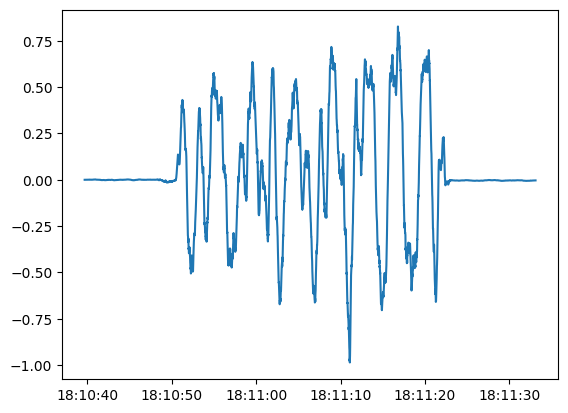

In [49]:
plt.plot(_imu_df.time, _imu_df.ax - val_ax)

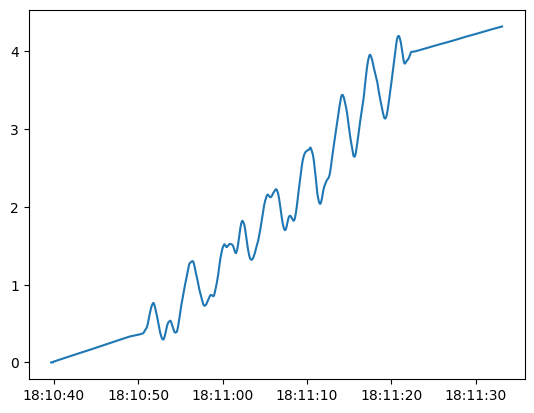

In [50]:
plt.plot(_imu_df.time, (_imu_df.ax.cumsum()*0.01))

In [56]:
_mean_val = _imu_df.vx[:200].diff().mean()

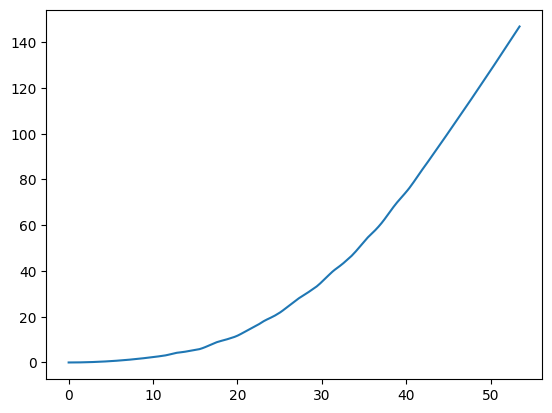

In [26]:
plt.plot(_imu_df.time, (_imu_df.ax.cumsum()*0.01).cumsum()*0.01)

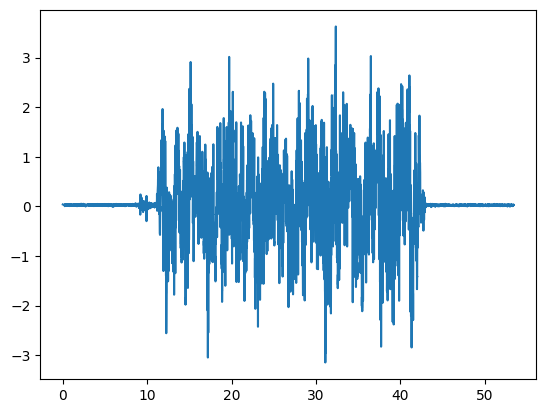

In [8]:
# plt.plot(_bosch_df["time"], _bosch_df["ax"])
# fit a curve
from scipy.optimize import curve_fit

# time to time stamp

xdata = np.array(_bosch_df["time"])
ydata = np.array(_bosch_df["ax"])
# popt, pcov = curve_fit(func, xdata, ydata)

plt.plot(xdata, ydata, label="Original Noised Data") 
# plt.plot(xdata, func(xdata, *popt), 'r-', label="Fitted Curve")

In [6]:
xdata

array([ 0.      ,  0.22893 ,  0.22927 , ..., 53.406894, 53.41444 ,
       53.422171])